<a href="https://colab.research.google.com/github/soham-chitnis10/hsi-pls-segg/blob/main/HSI_classify_labelled_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd drive/MyDrive/

/content/drive/MyDrive


In [3]:
import scipy.io as io
import matplotlib.pyplot as plt
import torch
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import numpy as np

def dim_reduc(hycube,n_components):
    new_hycube =np.reshape(hycube,(-1,hycube.shape[2]))
    pca = PCA(n_components,whiten=True,random_state=0)
    new_hycube = pca.fit_transform(new_hycube)
    new_hycube =np.reshape(new_hycube,(hycube.shape[0],hycube.shape[1],n_components))
    return new_hycube

def patchify(hycube,hycube_y,wsize,padding=True):
    pad = int((wsize-1)/2)
    N = hycube.shape[0]*hycube.shape[1] 
    if padding:
        hycube = np.pad(hycube,pad_width=((pad,pad),(pad,pad),(0,0)),constant_values=0)
    new_hycube = np.zeros((N,wsize,wsize,hycube.shape[2]))
    new_hycube_y = np.zeros((N))
    id = 0
    for r in range(pad,hycube.shape[0]-pad):
        for c in range(pad,hycube.shape[1]-pad):
            new_hycube[id,:,:,:] = hycube[r-pad:r+pad+1,c-pad:c+pad+1]
            new_hycube_y[id]=hycube_y[r-pad,c-pad]
            id += 1
    return new_hycube,new_hycube_y

def preprocess(hycube,hycube_y,n_components=6,split=True,wsize=15):
    new_hycube = dim_reduc(hycube,n_components)
    for i in range(1,9):
      hycube_y[hycube_y==i] = (i-1)
    X,y = patchify(new_hycube,hycube_y,wsize)
    if split:
        X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.80)
        X_train =np.reshape(X_train,(-1,X_train.shape[3],X_train.shape[1],X_train.shape[2]))
        X_test= np.reshape(X_test,(-1,X_test.shape[3],X_test.shape[1],X_test.shape[2]))
        y_train = y_train.astype(int)
        y_test = y_test.astype(int)
        X_train = X_train.astype(np.float32)
        X_test = X_test.astype(np.float32)
        X_train = torch.from_numpy(X_train)
        y_train = torch.from_numpy(y_train)
        X_test = torch.from_numpy(X_test)
        y_test = torch.from_numpy(y_test)
        return X_train,X_test,y_train,y_test
    X = np.reshape(X,(-1,X.shape[3],X.shape[1],X.shape[2]))
    X = X.astype(np.float32)
    y = y.astype(int)
    X = torch.from_numpy(X)
    y = torch.from_numpy(y)
    return X,y



In [4]:
import torch.nn as nn
class HSI_CNN(nn.Module):
    def __init__(self,in_channels=6,num_classes=8) -> None:
        super(HSI_CNN,self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels,in_channels*2,3),
                                   nn.BatchNorm2d(in_channels*2),
                                   nn.ReLU())
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels*2,in_channels*4,3),
                                   nn.BatchNorm2d(in_channels*4),
                                   nn.ReLU())
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels*4,in_channels*4,3),
                                   nn.BatchNorm2d(in_channels*4),
                                   nn.MaxPool2d(2,2),
                                   nn.ReLU())
        self.flatten = nn.Flatten()
        self.linear1 = nn.Sequential(nn.Linear(384,128),
                                     nn.ReLU())
        self.linear2 = nn.Linear(128,num_classes)

    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.linear2(x)
        return x


In [5]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import scipy.io as sio
# from utils import preprocess
from sklearn.model_selection import train_test_split
class HsiDataset(Dataset):
    def __init__(self,transform=ToTensor(),training=True):
        self.transform = transform
        self.training = training
        data = sio.loadmat('./data/plastics_data.mat')
        data_y = sio.loadmat('./data/plastics_gt.mat')
        self.hycube = data['data_0']
        self.hycube_y = data_y['plastics_gt']
        self.X_train,self.X_test,self.y_train,self.y_test = preprocess(self.hycube,self.hycube_y)
    def __len__(self):
        if self.training:
            return len(self.y_train)
        return len(self.y_test)
    def __getitem__(self, index):
        if self.training:
            X = self.X_train[index]
            y = self.y_train[index]
        else:
            X = self.X_test[index]
            y = self.y_test[index]
        return X,y



Epoch: 1 Train Loss: 0.054823145270347595 Accuracy: 0.9850084714994554
Epoch: 2 Train Loss: 0.03376692160964012 Accuracy: 0.9891080721287668
Epoch: 3 Train Loss: 0.029373811557888985 Accuracy: 0.988366815926419
Epoch: 4 Train Loss: 0.027208130806684494 Accuracy: 0.9904846907902699
Epoch: 5 Train Loss: 0.026003707200288773 Accuracy: 0.9910444148614305
Epoch: 6 Train Loss: 0.025032823905348778 Accuracy: 0.9911351809270241
Epoch: 7 Train Loss: 0.024578483775258064 Accuracy: 0.9899400943967083
Epoch: 8 Train Loss: 0.024609480053186417 Accuracy: 0.9914982451893986
Epoch: 9 Train Loss: 0.02409597672522068 Accuracy: 0.9911351809270241
Epoch: 10 Train Loss: 0.023290183395147324 Accuracy: 0.9915587558997943
Epoch: 11 Train Loss: 0.02391047775745392 Accuracy: 0.9900308604623018
Epoch: 12 Train Loss: 0.02285783551633358 Accuracy: 0.9919974585501634
Epoch: 13 Train Loss: 0.023282580077648163 Accuracy: 0.9924210335229335
Epoch: 14 Train Loss: 0.022744227200746536 Accuracy: 0.9928143531405059
Epoch:

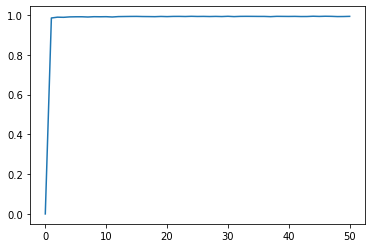

In [ ]:
# from dataset import HsiDataset
from torch.utils.data import DataLoader
# from model import HSI_CNN
from torch.optim import Adam
import torch.nn as nn
import torch
import scipy.io as sio
# import utils 
import matplotlib.pyplot as plt
train_data = HsiDataset()
test_data = HsiDataset(training=False)
train_dataloader = DataLoader(train_data,batch_size=8,shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=8)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HSI_CNN().to(device)
optimizer = Adam(model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()
best_acc = 0
acc_list = [0]
for epoch in range(50):
    model.train()
    train_loss =0
    for i,(X,y) in enumerate(train_dataloader):
        X,y = X.to(device), y.to(device)
        logits = model(X)
        batch_loss = criterion(logits,y)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        train_loss += batch_loss
        # if i%100 ==0:
        #     print(f'Train Loss: {batch_loss} batch_id: {i}')
    # print("Starting eval")
    avg_train_loss = train_loss/(i+1)
    model.eval()
    epoch_acc = 0
    with torch.no_grad():
        for i,(X,y) in enumerate(test_dataloader):
            X,y = X.to(device), y.to(device)
            logits = model(X)
            batch_loss = criterion(logits,y)
            y_score,y_pred= logits.max(dim=1)
            acc = (y==y_pred).sum()/y.size(0)
            acc = acc.item()
            epoch_acc += acc
            # print(f'Batch Accuracy: {acc} batch_id: {i}')
        if (epoch_acc/(i+1)) > best_acc:
            torch.save(model.state_dict(),'models/best_model-2.pth')
            best_acc = epoch_acc/(i+1)
        avg_epoch_acc = epoch_acc/(i+1)
    print(f'Epoch: {epoch+1} Train Loss: {avg_train_loss} Accuracy: {avg_epoch_acc}')
    acc_list.append(avg_epoch_acc)
    
epoch_list = list(range(0,51))
plt.plot(epoch_list,acc_list)
plt.show()


In [ ]:
print(f'Best Accuracy: {best_acc}')

Best Accuracy: 0.9937673968292388


In [12]:
from sklearn.metrics import classification_report, cohen_kappa_score,confusion_matrix,accuracy_score
import seaborn as sns
from torch.utils.data import DataLoader
def report(model,filename=None):
    test_dataset = HsiDataset(training=False)
    test_loader = DataLoader(test_dataset,66100)
    it = test_loader._get_iterator()
    X_test,y_test = it.next()
    logits = model(X_test)
    _,y_pred = logits.max(dim=1)
    y_test = y_test.numpy()
    y_pred = y_pred.numpy()
    cls_report = classification_report(y_test,y_pred)
    oa = accuracy_score(y_test,y_pred)
    ckappa = cohen_kappa_score(y_test,y_pred)
    confusion = confusion_matrix(y_test,y_pred)
    list_diag = np.diag(confusion)
    list_row_sum = np.sum(confusion, axis=1)
    each_acc = np.nan_to_num(list_diag/list_row_sum)
    classes = ["Background","PA","PE","PF","PMMA","PS","PVC","UP"]
    sns_plot = sns.heatmap(confusion,xticklabels=classes,yticklabels=classes)
    plt.show()
    print(cls_report)
    print(f'OA: {oa}')
    print(f'Cohen Kappa Score: {ckappa}')
    print(f'\nEach class accuracy')
    
    for (a,b) in zip(classes,each_acc):
        print(f"{a}: {b}")
    if filename:
        with open(filename,'w') as f:
            print(cls_report,file=f)
            print(f'OA: {oa}',file=f)
            print(f'Cohen Kappa Score: {ckappa}',file =f)
            print(f'\nEach class accuracy',file=f)
            for (a,b) in zip(classes,each_acc):
                print(f"{a}: {b}",file=f)
            f.close()
def visulize(model,hycube,hycube_y):
  h = hycube.shape[0]
  w = hycube.shape[1]
  X,y = preprocess(hycube,hycube_y,split=False,wsize=15)
  pred_img = torch.zeros((h,w))
  id =0
  for i in range(h):
      for j in range(w):
          patch = X[id,:,:,:]
          patch = torch.unsqueeze(patch,0)
          # print(patch.size())
          logit = model(patch)
          y_score,y_pred = logit.max(dim=1)
          pred_img[i,j] = y_pred
          id+=1
  predicted_img = pred_img.numpy()
  f,(axs1,axs2) = plt.subplots(1,2,figsize=(15,8))
  axs1.set_title('Ground Truth')
  axs2.set_title('Prediction')
  axs1.imshow(hycube_y)
  axs2.imshow(predicted_img)
  plt.show()

In [7]:
eval_model = HSI_CNN()
eval_model.load_state_dict(torch.load('models/best_model-2.pth'))
eval_model.eval()

HSI_CNN(
  (conv1): Sequential(
    (0): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Sequential(
    (0): Linear(in_features=384, out_features=128, bias=True)
    (1): ReLU()
  )
  (linear2): Linear(in_features=128, out_features=8, bias=True)
)

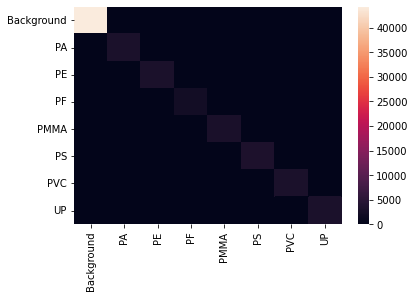

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     44434
           1       0.99      0.99      0.99      3215
           2       0.99      0.99      0.99      3269
           3       0.99      0.99      0.99      2213
           4       0.99      0.99      0.99      3133
           5       1.00      0.99      0.99      3334
           6       1.00      0.98      0.99      3313
           7       0.99      0.99      0.99      3189

    accuracy                           0.99     66100
   macro avg       0.99      0.99      0.99     66100
weighted avg       0.99      0.99      0.99     66100

OA: 0.9939939485627837
Cohen Kappa Score: 0.9887074746943167

Each class accuracy
Background: 0.9963766485124004
PA: 0.9931570762052877
PE: 0.9911287855613338
PF: 0.9945774966109354
PMMA: 0.988828598787105
PS: 0.9886022795440912
PVC: 0.981285843646242
UP: 0.9880840388836626


In [11]:
report(eval_model)

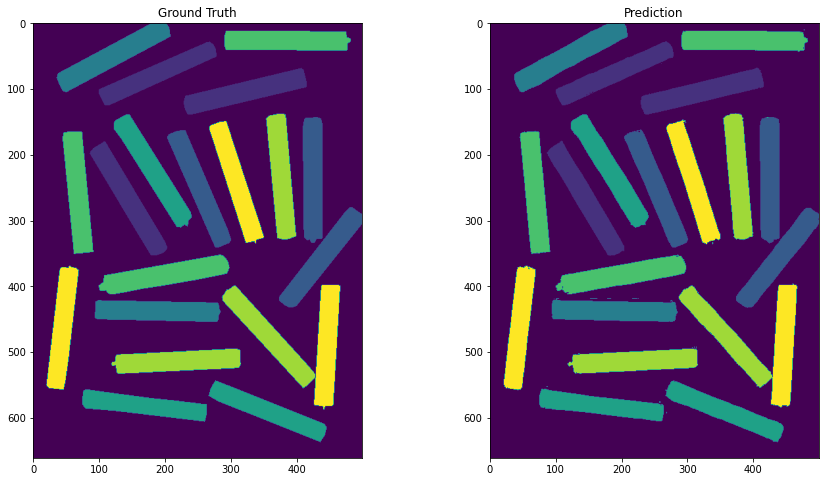

In [13]:
data = sio.loadmat('./data/plastics_data.mat')
data_y = sio.loadmat('./data/plastics_gt.mat')
hycube = data['data_0']
hycube_y = data_y['plastics_gt']
visulize(eval_model,hycube,hycube_y)